## IMPORTS

In [124]:
import cv2
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

## DATASET IMPORT

In [125]:
dataset_folder = "./IC dataset"

## Conversion of images of train and test folder to .npy files
train_folder = os.path.join(dataset_folder, "train") # path of train folder
test_folder = os.path.join(dataset_folder, "test") # path of test folder


train_images = [] # list of all images in train folder
test_images = [] # list of all images in test folder

for image in os.listdir(train_folder):
    train_images.append(os.path.join(train_folder, image)) # append the path of each image to the list

for image in os.listdir(test_folder):
    test_images.append(os.path.join(test_folder, image)) # append the path of each image to the list

## sort the images in the list
train_images.sort()
test_images.sort()

## backup of the list
train_images_backup = train_images
test_images_backup = test_images

## resize all images to 512x512
train_images = [cv2.resize(cv2.imread(image), (512, 512)) for image in train_images]
test_images = [cv2.resize(cv2.imread(image), (512, 512)) for image in test_images]

## number of images in train and test folder
n_train = len(train_images)
n_test = len(test_images) 

print("Number of images in train folder: ", n_train)
print("Number of images in test folder: ", n_test)

Number of images in train folder:  101
Number of images in test folder:  17


#### SAMPLE VISUALIZATION

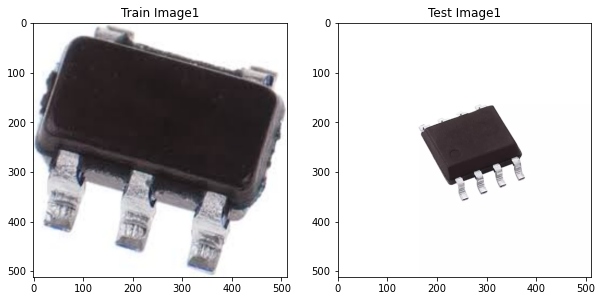

In [126]:
## visualize the images as asubplot , one from each folder
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_images[0])
ax[0].set_title("Train Image1")
ax[1].imshow(test_images[0])
ax[1].set_title("Test Image1")
plt.show()

## FEATURE EXTRACTION WITH SIFT

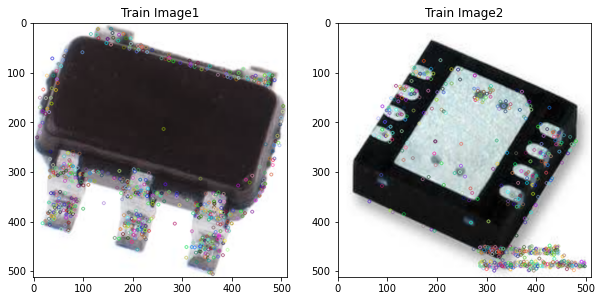

In [127]:
## extract features from train images using SIFT
sift = cv2.SIFT_create()
train_features = [] # list of features of train images

grays = [] # list of grayscale images of train images
kps = [] # list of keypoints of train images
imgs = [] # list of images of train images

for image in train_images:
    img = image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grays.append(gray)
    kp, des = sift.detectAndCompute(gray, None)
    kps.append(kp)
    imgs.append(img)
    train_features.append(des)


## visulaize the features of train images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.drawKeypoints(imgs[0], kps[0], None))
ax[0].set_title("Train Image1")
ax[1].imshow(cv2.drawKeypoints(imgs[29], kps[29], None))
ax[1].set_title("Train Image2")
plt.show()

## CODEBOOK GENERATION

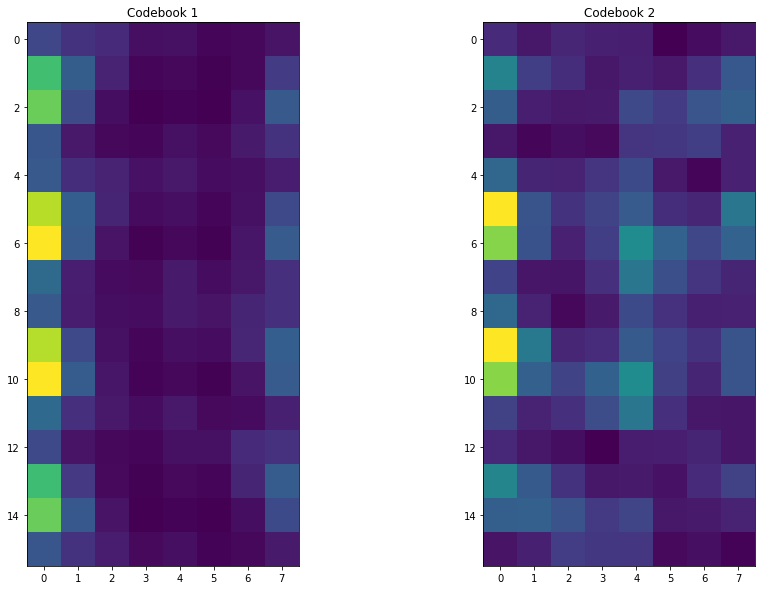

In [128]:
# Stack the features for training
all_features = np.vstack(train_features)

# Perform feature quantization by creating a codebook
k = 2 # number of clusters

## kmeans algorithm
def kmeans(X, k):
    centroids = X[np.random.choice(X.shape[0], k, replace=False), :]
    while True:
        distances = np.sqrt(np.sum((X[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2, axis=2))
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids

codebook = kmeans(all_features, k) # codebook of size k x 128

## visualize the codebook
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(codebook[0].reshape(16, 8))
ax[0].set_title("Codebook 1")
ax[1].imshow(codebook[1].reshape(16, 8))
ax[1].set_title("Codebook 2")
plt.show()

## BoVW HISTOGRAM GENERATION

In [129]:
### BOVW CALCULATION ###
## calculate the histogram of each image
train_histograms = [] # list of histograms of train images
for i in range(n_train):
    histogram = np.zeros(k)
    for feature in train_features[i]:
        distances = np.sqrt(np.sum((feature - codebook) ** 2, axis=1))
        closest = np.argmin(distances)
        histogram[closest] += 1
    train_histograms.append(histogram)

In [130]:
## label map
label_map = {1: "No PIN", 0: "PIN"}

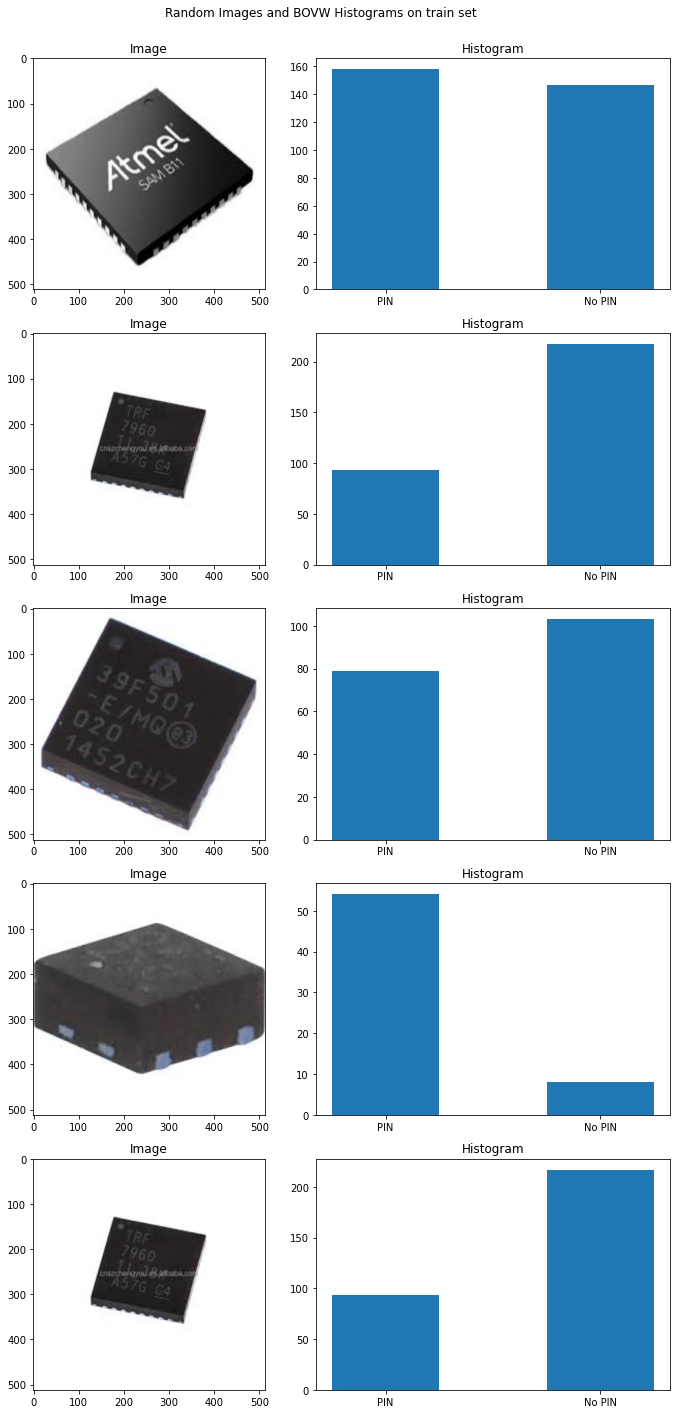

In [131]:
## visualize 5 random images and shoe predicted vs real
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    index = np.random.randint(0, n_train)
    ax[i][0].imshow(imgs[index])
    ax[i][0].set_title("Image")
    ax[i][1].bar(range(k), train_histograms[index], width=0.5)
    ## add xtick names from label map
    ax[i][1].set_xticks(range(k))
    ax[i][1].set_xticklabels([label_map[i] for i in range(k)])
    ax[i][1].set_title("Histogram")
plt.tight_layout()
plt.suptitle("Random Images and BOVW Histograms on train set\n\n")
plt.tight_layout()
plt.show()

## LABEL ANNOTATION AND SMOTE FOR DATA IMBALANCE

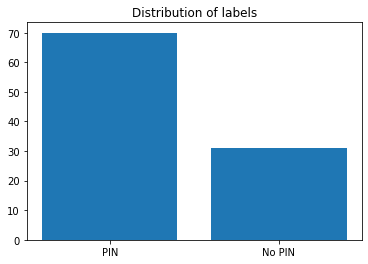

In [132]:
# labels from histogram
# labels = []
# for histogram in train_histograms:
#     if histogram[0] > histogram[1]:
#         labels.append(0)
#     else:
#         labels.append(1)

## labelling by lfilename,
## if startws with wp then pin is present else no pin
labels = []
for image in train_images_backup:
    filename = image.split("/")[-1]
    if filename.startswith("wp"):
        labels.append(1)
    else:
        labels.append(0)


        
# distribution of labels with legend
plt.bar(label_map.keys(), np.bincount(labels))
## add xtick names from label map
plt.xticks(range(k))
plt.xticks(list(label_map.keys()), list(label_map.values()))
plt.title("Distribution of labels")
plt.show()

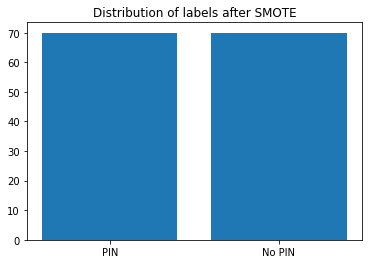

In [133]:
## SMOtE for imbalanced data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_histograms, labels)

## distribution of labels after smote
plt.bar(label_map.keys(), np.bincount(y_res))
## add xtick names from label map
plt.xticks(range(k))
plt.xticks(list(label_map.keys()), list(label_map.values()))
plt.title("Distribution of labels after SMOTE")
plt.show()


train_histograms = X_res # histograms after smote
labels = y_res # labels after smote

In [134]:
## Augment the data by flipping the images
train_histograms = np.vstack((train_histograms, train_histograms))
labels = np.hstack((labels, labels))


## SUPPORT VECTOR MACHINES

Accuracy of the model:  0.5071428571428571
Confusion Matrix:  [[90 50]
 [88 52]]


/home/abb/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


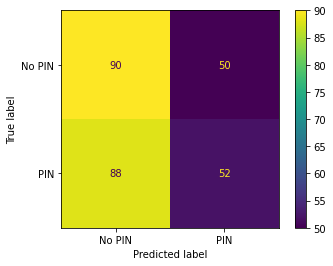

Precision:  0.5098039215686274
Recall:  0.37142857142857144
F1 Score:  0.4297520661157025
AUC:  0.5071428571428571


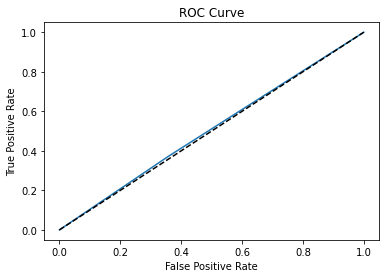

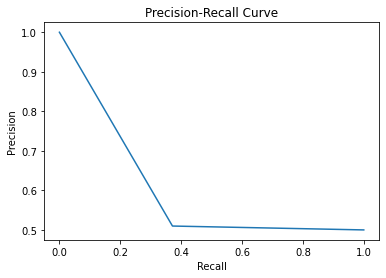

In [135]:

## train the SVM classifier
clf = SVC(kernel="linear")
clf.fit(train_histograms, labels)

## predict the labels of test images
preds = clf.predict(train_histograms)

## calculate the accuracy of the model
accuracy = accuracy_score(labels, preds)
print("Accuracy of the model: ", accuracy)

## calculate the confusion matrix
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
cm = confusion_matrix(labels, preds)
print("Confusion Matrix: ", cm)

## visualize the confusion matrix with label map
plot_confusion_matrix(clf, train_histograms, labels, display_labels=list(label_map.values()))
plt.show()

## calculate the precision and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
print("Precision: ", precision)
print("Recall: ", recall)

## calculate the F1 score
from sklearn.metrics import f1_score
f1 = f1_score(labels, preds)
print("F1 Score: ", f1)

## calculate the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(labels, preds)
auc = roc_auc_score(labels, preds)
print("AUC: ", auc)

## visualize the ROC curve
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

## calculate the precision-recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(labels, preds)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


## FINAL PREDICTIONS

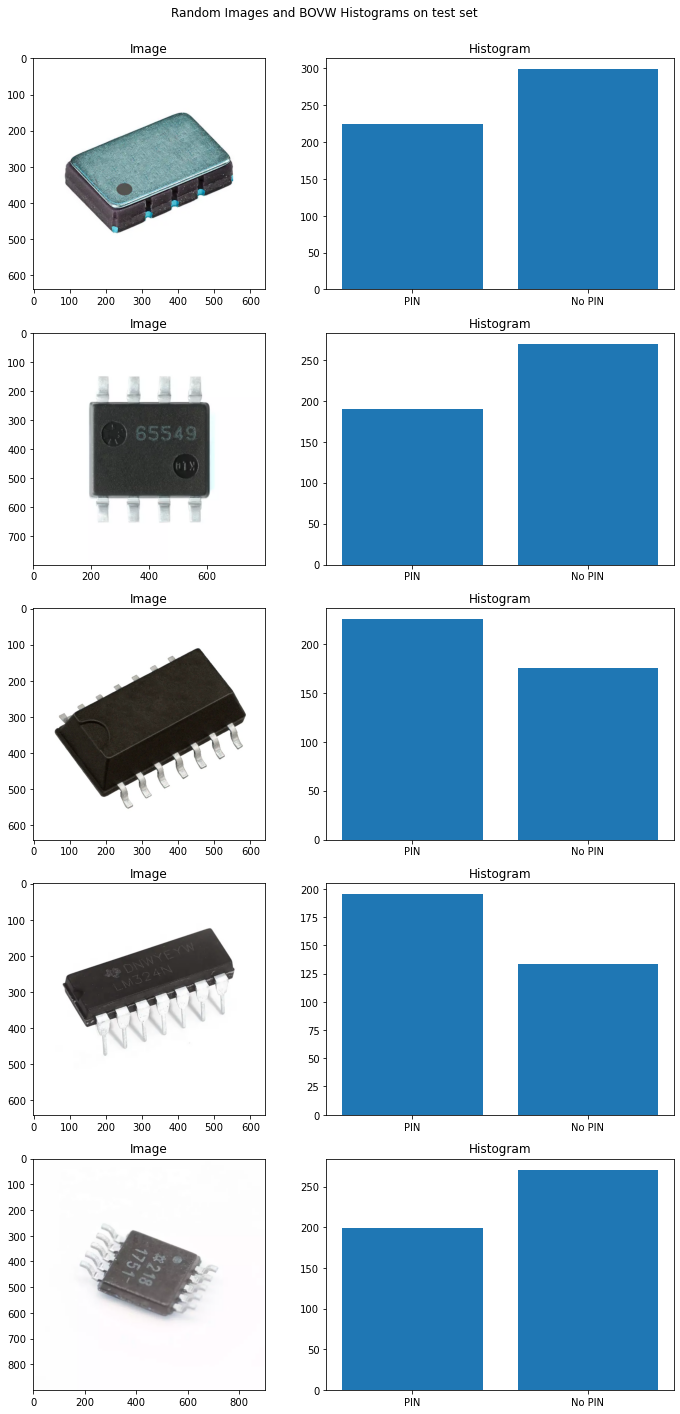

In [139]:
## funtion to predict labels on unseen images
def predict(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    histogram = np.zeros(k)
    for feature in des:
        distances = np.sqrt(np.sum((feature - codebook) ** 2, axis=1))
        closest = np.argmin(distances)
        histogram[closest] += 1
    # pred = clf.predict([histogram])
    pred = np.argmax(histogram)
    return pred, histogram

def predict_svm(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    histogram = np.zeros(k)
    for feature in des:
        distances = np.sqrt(np.sum((feature - codebook) ** 2, axis=1))
        closest = np.argmin(distances)
        histogram[closest] += 1
    pred = clf.predict([histogram])
    return pred, histogram

## predict the labels of test images with BOVW only
preds = []
histograms = []
for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder, filename))
    pred,histogram = predict(img)
    preds.append(pred)
    histograms.append(histogram)
    
## visualize the predicted labels and histograms on the test set
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    index = np.random.randint(0, n_test)
    ax[i][0].imshow(cv2.imread(os.path.join(test_folder, os.listdir(test_folder)[index])))
    ax[i][0].set_title("Image")
    ax[i][1].bar(range(k), histograms[index])
    ## add xtick names from label map
    ax[i][1].set_xticks(range(k))
    ax[i][1].set_xticklabels([label_map[i] for i in range(k)])
    ax[i][1].set_title("Histogram")
    
plt.suptitle("Random Images and BOVW Histograms on test set\n\n")
plt.tight_layout()
plt.show()

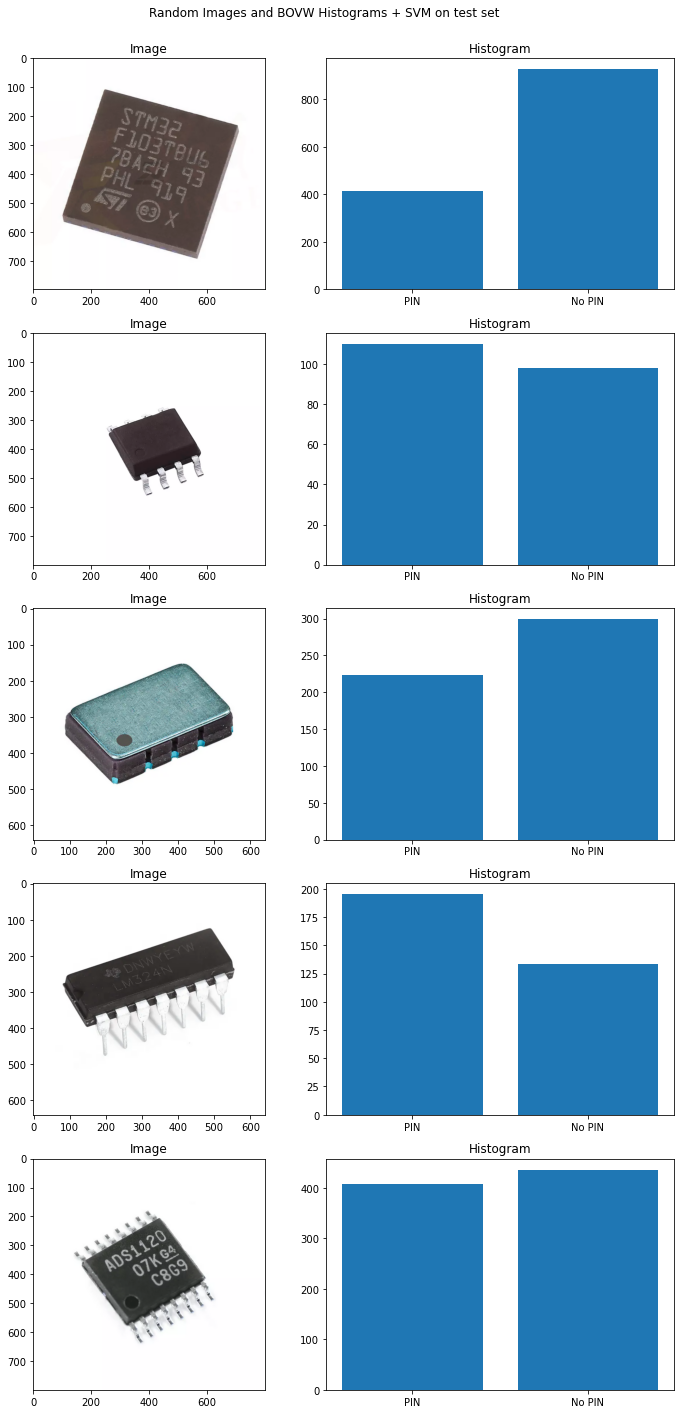

In [141]:
## Pred with BOVW and SVM
preds = []
histograms = []
for filename in os.listdir(test_folder):
    img = cv2.imread(os.path.join(test_folder, filename))
    pred,histogram = predict_svm(img)
    preds.append(pred)
    histograms.append(histogram)

## visualize the predicted labels and histograms on the test set
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    index = np.random.randint(0, n_test)
    ax[i][0].imshow(cv2.imread(os.path.join(test_folder, os.listdir(test_folder)[index])))
    ax[i][0].set_title("Image")
    ax[i][1].bar(range(k), histograms[index])
    ## add xtick names from label map
    ax[i][1].set_xticks(range(k))
    ax[i][1].set_xticklabels([label_map[i] for i in range(k)])
    ax[i][1].set_title("Histogram")

plt.suptitle("Random Images and BOVW Histograms + SVM on test set\n\n")
plt.tight_layout()
plt.show()